C:\Users\naso_\AppData\Local\Temp\ipykernel_29016\4236639590.py:121: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reggio_centroid = gdf_reggio.geometry.centroid.iloc[0]
C:\Users\naso_\AppData\Local\Temp\ipykernel_29016\4236639590.py:140: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


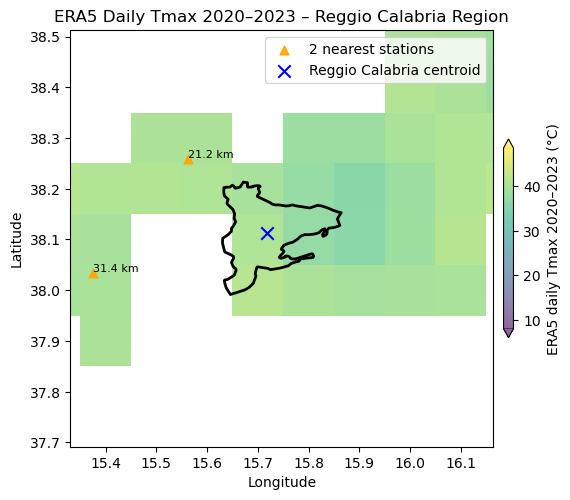

In [61]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------------------------------------------------
# Paths
# ----------------------------------------------------------------------
era5_dir = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\derived-era5-land-daily-statistics")
reggio_path = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\reggio_calabria.gpkg")
stations_path = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\italian_stations.gpkg")

# ----------------------------------------------------------------------
# Load ERA5 Tmax (all years in folder) and convert to °C
# ----------------------------------------------------------------------
era5_files = sorted(era5_dir.glob("*2m_temperature_daily_maximum.nc"))

ds_list = [xr.open_dataset(f) for f in era5_files]
ds = xr.concat(ds_list, dim="valid_time")

# Kelvin → Celsius
ds["t2m"] = ds["t2m"] - 273.15

# Tmax over the whole period 2020–2025 (per grid cell)
tmax_2020_2025 = ds["t2m"].max(dim="valid_time", skipna=True)

# Make the color range a bit tighter to show more variability
tmin = float(tmax_2020_2025.min())
tmax = float(tmax_2020_2025.max())
vmin = tmin + 0.5
vmax = tmax - 0.5

# ----------------------------------------------------------------------
# Load Reggio Calabria boundary and stations
# ----------------------------------------------------------------------
gdf_reggio = gpd.read_file(reggio_path)
gdf_stations = gpd.read_file(stations_path).to_crs(gdf_reggio.crs)

# ----------------------------------------------------------------------
# Compute distance (km) from Reggio centroid to each station
#   -> use metric CRS only for distance, then bring values back
# ----------------------------------------------------------------------
metric_crs = "EPSG:32633"  # UTM zone 33N (good for southern Italy)

reggio_metric = gdf_reggio.to_crs(metric_crs)
stations_metric = gdf_stations.to_crs(metric_crs)

reggio_centroid_metric = reggio_metric.geometry.centroid.iloc[0]

stations_metric["dist_km"] = (
    stations_metric.geometry.distance(reggio_centroid_metric) / 1000.0
)

# attach distance to original CRS GeoDataFrame
gdf_stations["dist_km"] = stations_metric["dist_km"]

# keep ONLY the 5 nearest stations
nearest5 = gdf_stations.sort_values("dist_km").head(2).copy()

# ----------------------------------------------------------------------
# Bounding box around Reggio
# ----------------------------------------------------------------------
min_lon, min_lat, max_lon, max_lat = gdf_reggio.total_bounds
lon_margin = 0.3
lat_margin = 0.3

# ----------------------------------------------------------------------
# Plot
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))  # square frame

# ERA5 Tmax map with a short colorbar
tmax_2020_2025.plot(
    ax=ax,
    cmap="viridis",
    alpha=0.6,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={
        "shrink": 0.35,
        "pad": 0.02,
        "label": "ERA5 daily Tmax 2020–2023 (°C)",
    },
)

# Reggio Calabria outline: black border, transparent interior
gdf_reggio.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=2,
    label="Reggio Calabria boundary",
)

# Plot only the 5 nearest stations (orange triangles)
nearest5.plot(
    ax=ax,
    color="orange",
    markersize=40,
    marker="^",
    alpha=0.9,
    label="2 nearest stations",
)

# Label those 5 stations with their distance in km
for _, row in nearest5.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    label = f"{row['dist_km']:.1f} km"
    ax.text(
        x,
        y,
        label,
        fontsize=8,
        ha="left",
        va="bottom",
        color="black",
    )

# Reggio centroid (blue X)
reggio_centroid = gdf_reggio.geometry.centroid.iloc[0]
ax.scatter(
    reggio_centroid.x,
    reggio_centroid.y,
    color="blue",
    s=80,
    marker="x",
    label="Reggio Calabria centroid",
)

# Tighter map frame around Reggio
ax.set_xlim(min_lon - lon_margin, max_lon + lon_margin)
ax.set_ylim(min_lat - lat_margin, max_lat + lat_margin)
ax.set_aspect("equal", adjustable="box")

# Labels and legend
ax.set_title("ERA5 Daily Tmax 2020–2023 – Reggio Calabria Region", fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [52]:

# ------------------------------------------------------------------
# 1. Load Reggio boundary and stations
# ------------------------------------------------------------------
reggio_path   = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\reggio_calabria.gpkg")
stations_path = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\italian_stations.gpkg")

gdf_reggio   = gpd.read_file(reggio_path)
gdf_stations = gpd.read_file(stations_path)

# ------------------------------------------------------------------
# 2. Reproject to a metric CRS (UTM zone 33N is fine for Reggio area)
#    This is IMPORTANT so distances are in meters, not degrees.
# ------------------------------------------------------------------
target_crs = "EPSG:32633"   # UTM 33N

gdf_reggio   = gdf_reggio.to_crs(target_crs)
gdf_stations = gdf_stations.to_crs(target_crs)

# ------------------------------------------------------------------
# 3. Compute centroid of Reggio Calabria
# ------------------------------------------------------------------
reggio_centroid = gdf_reggio.geometry.centroid.iloc[0]

# ------------------------------------------------------------------
# 4. Compute distance from each station to the centroid
# ------------------------------------------------------------------
gdf_stations["dist_m"] = gdf_stations.geometry.distance(reggio_centroid)
gdf_stations["dist_km"] = gdf_stations["dist_m"] / 1000.0

# ------------------------------------------------------------------
# 5. Get the 5 closest stations
# ------------------------------------------------------------------
nearest5 = (
    gdf_stations
    .sort_values("dist_m")
    .head(5)
    .copy()
)

# Change "name" to whatever your station-name field is
cols_to_show = ["dist_km"]
if "name" in nearest5.columns:
    cols_to_show = ["name", "dist_km"]
elif "station" in nearest5.columns:
    cols_to_show = ["station", "dist_km"]

print("Five closest stations to Reggio centroid (km):")
print(nearest5[cols_to_show])

# If you also want the centroid coordinates in this CRS:
print("\nCentroid coordinates (UTM 33N):", reggio_centroid.x, reggio_centroid.y)


Five closest stations to Reggio centroid (km):
        dist_km
1066  21.198730
1049  31.442780
1102  31.465735
1109  34.367485
1022  42.934080

Centroid coordinates (UTM 33N): 562956.6417997973 4218571.072779264


C:\Users\naso_\AppData\Local\Temp\ipykernel_29016\2969974896.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reggio_centroid = gdf_reggio.geometry.centroid.iloc[0]
C:\Users\naso_\AppData\Local\Temp\ipykernel_29016\2969974896.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")


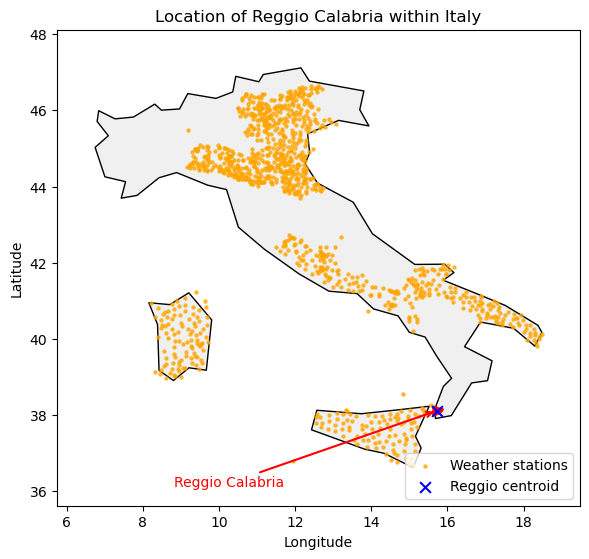

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------------------------------
# Paths to your local data
# ----------------------------------------------------
reggio_path   = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\reggio_calabria.gpkg")
stations_path = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\Data\italian_stations.gpkg")  # optional

# ----------------------------------------------------
# 1. Load Italy outline from Natural Earth (online)
# ----------------------------------------------------
# 110m admin-0 countries shapefile (zipped)
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(world_url)

# Depending on the version, the country name field may be 'ADMIN' or 'name'
if "ADMIN" in world.columns:
    italy = world[world["ADMIN"] == "Italy"].to_crs(epsg=4326)
else:
    italy = world[world["name"] == "Italy"].to_crs(epsg=4326)

# ----------------------------------------------------
# 2. Load Reggio Calabria boundary and stations
# ----------------------------------------------------
gdf_reggio = gpd.read_file(reggio_path).to_crs(italy.crs)
gdf_stations = gpd.read_file(stations_path).to_crs(italy.crs)  # optional

# Centroid of Reggio
reggio_centroid = gdf_reggio.geometry.centroid.iloc[0]

# ----------------------------------------------------
# 3. Plot zoomed-out map
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 8))

# Italy outline
italy.plot(ax=ax, facecolor="#f0f0f0", edgecolor="black", linewidth=1)

# Reggio Calabria boundary: red outline, transparent inside
gdf_reggio.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    label="Reggio Calabria"
)

# Optional: all Italian stations as small orange dots
gdf_stations.plot(
    ax=ax,
    color="orange",
    markersize=5,
    alpha=0.7,
    label="Weather stations"
)

# Reggio centroid (blue X)
ax.scatter(
    reggio_centroid.x,
    reggio_centroid.y,
    color="blue",
    s=60,
    marker="x",
    zorder=5,
    label="Reggio centroid"
)

# Label with arrow
ax.annotate(
    "Reggio Calabria",
    xy=(reggio_centroid.x, reggio_centroid.y),
    xytext=(reggio_centroid.x - 4, reggio_centroid.y - 2),
    arrowprops=dict(arrowstyle="->", color="red", linewidth=1.5),
    fontsize=10,
    color="red",
    ha="right"
)

# Frame around Italy with a bit of margin
minx, miny, maxx, maxy = italy.total_bounds
ax.set_xlim(minx - 1, maxx + 1)
ax.set_ylim(miny - 1, maxy + 1)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Location of Reggio Calabria within Italy", fontsize=12)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()
